<a href="https://colab.research.google.com/github/fathanzys/NLP-Fathan/blob/main/Analisis_Sentimen_Kabur_Aja_Dulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analisis Komentar Pada Postingan Kabur Aja Dulu TIKTOK**

Sample :
Tiktok

#**Library**

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk sastrawi wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [16]:
# Import semua yang dibutuhkan
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#**Data Collection**

In [18]:
# Load CSV
df = pd.read_csv('/content/dataset_tiktok-comments-scraper_2025-05-19_03-40-24-120.csv')  # Ganti dengan nama filemu
df = df[['text']]  # Hanya ambil kolom komentar

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("Jumlah data:", len(df))
df.head()

Jumlah data: 1000


,text
0,someday i will 100% leave this country
1,keep Up Bang
2,kocag bgt bapak nya😂 aku mah kalo ada kesempat...
3,kerja serius gaji bercanda🤣🤭\n#kaburajadulu
4,emang nasionalisme Bahlil kyk gimana sih???


#**Preprocessing Text**

In [21]:
# Buat fungsi pembersih teks
stemmer = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().get_stop_words()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stopword]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)
df[['text', 'clean_text']].head()

,text,clean_text
0,someday i will 100% leave this country,someday i will leave this country
1,keep Up Bang,keep up bang
2,kocag bgt bapak nya😂 aku mah kalo ada kesempat...,kocag bgt bapak nya aku mah kalo sempat kabura...
3,kerja serius gaji bercanda🤣🤭\n#kaburajadulu,kerja serius gaji canda kaburajadulu
4,emang nasionalisme Bahlil kyk gimana sih???,emang nasionalisme bahlil kyk gimana sih


#**Labelling Sentimen**

In [22]:
from textblob import TextBlob
import nltk
nltk.download('punkt')  # pastikan tokenisasi jalan

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 'positif'
    elif polarity < -0.1:
        return 'negatif'
    else:
        return 'netral'

# Buat kolom sentimen
df['sentimen'] = df['clean_text'].apply(get_sentiment)
df['sentimen'].value_counts()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,count
sentimen,
netral,983
positif,11
negatif,6


#**Modelling**

In [23]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X = tfidf.fit_transform(df['clean_text'])
y = df['sentimen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran Data Latih:", X_train.shape)
print("Ukuran Data Uji:", X_test.shape)

Ukuran Data Latih: (800, 5000)
Ukuran Data Uji: (200, 5000)


In [24]:
# Pakai Linear SVC (cepat dan akurat)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))

Akurasi: 0.985


#**Evaluation**

In [29]:
# Evaluasi lengkap
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         1
      netral       0.98      1.00      0.99       197
     positif       0.00      0.00      0.00         2

    accuracy                           0.98       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.97      0.98      0.98       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


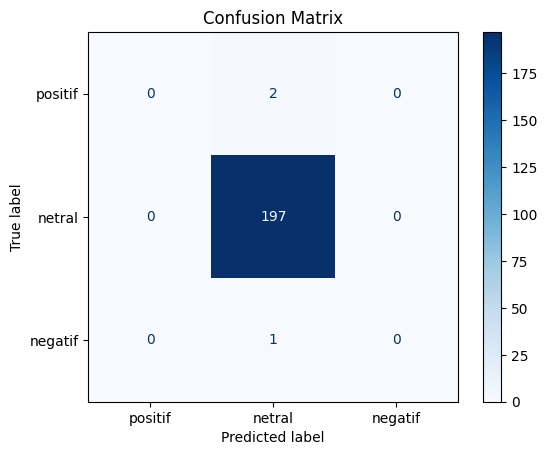

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'netral', 'negatif'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positif', 'netral', 'negatif'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#**Confussion Matrix**

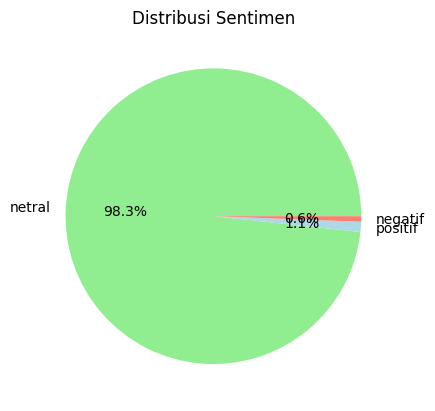

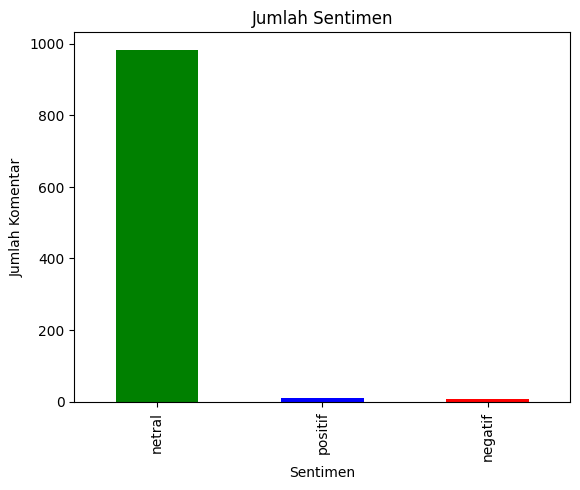

In [26]:
# Pie Chart
df['sentimen'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'salmon'])
plt.title("Distribusi Sentimen")
plt.ylabel("")
plt.show()

# Bar Chart
df['sentimen'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title("Jumlah Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Komentar")
plt.show()

#**Visualisasi**

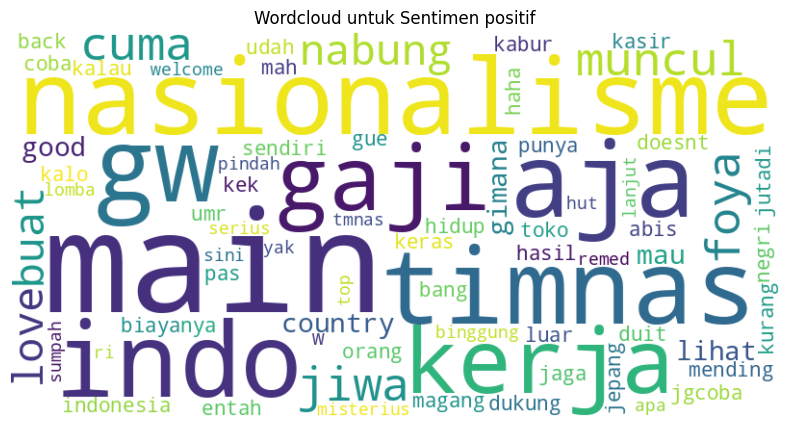

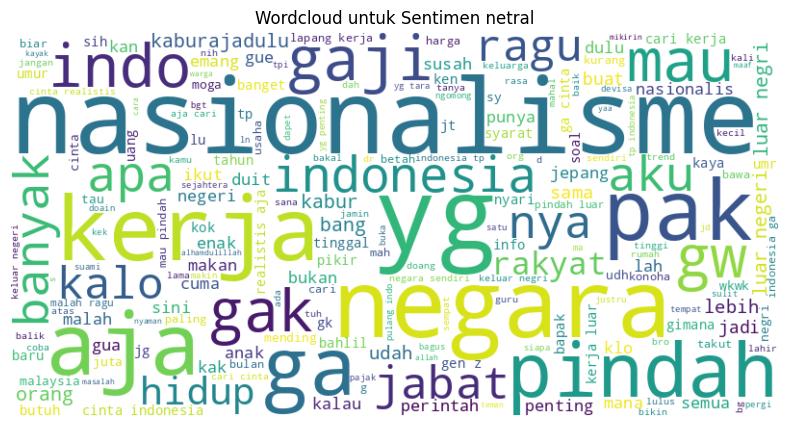

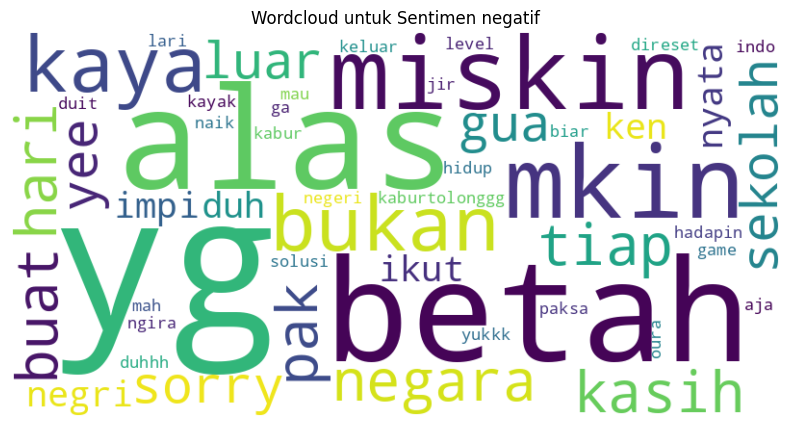

In [27]:
# Buat Wordcloud untuk setiap sentimen
for kategori in ['positif', 'netral', 'negatif']:
    teks = " ".join(df[df['sentimen'] == kategori]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(teks)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud untuk Sentimen {kategori}")
    plt.show()